In [22]:
# get gps data and do interpolate

import pandas as pd
import numpy as np

# Select start and end date
start_date = '2023-07-14 10:52:30'
end_date = '2023-07-14 11:00:00'

# Load the CSV data_gps into a data_gpsFrame
data_gps = pd.read_csv('data_0714/pixhawk_gps_1689322326086276514.csv', skipinitialspace=True)

# Convert received_time to datetime format
data_gps['received_time'] = pd.to_datetime(data_gps['received_time'], unit='ns')

# Localize the timestamp to GMT first (assuming the original time is in GMT)
data_gps['received_time'] = data_gps['received_time'].dt.tz_localize('GMT')

# Convert to Rome time
data_gps['received_time'] = data_gps['received_time'].dt.tz_convert('Europe/Rome')

# Filter data based on the date range
mask = (data_gps['received_time'] > start_date) & (data_gps['received_time'] <= end_date)
data_gps = data_gps.loc[mask]

print(data_gps.head())

# Sort the DataFrame by received_time
data_gps = data_gps.sort_values('received_time')

# Replace empty strings with NaN
data_gps.replace('', np.nan, inplace=True)

# Set received_time as the index (required for interpolation)
data_gps.set_index('received_time', inplace=True)

# Interpolate the missing values based on the index (received_time)
data_gps_interpolated = data_gps.astype('float').interpolate(method='time')

# Reset the index
data_gps_interpolated.reset_index(inplace=True)

data_gps_interpolated = data_gps_interpolated.drop(data_gps_interpolated.index[0])

# Divide by a large number to get latitude and longitude values in the correct range
data_gps_interpolated['lat'] = data_gps_interpolated['lat'] / 1e7
data_gps_interpolated['lon'] = data_gps_interpolated['lon'] / 1e7

# Print the resulting DataFrame

data_gps_interpolated
data_gps.reset_index(inplace=True)


                           received_time   altitude          lat          lon  \
1588 2023-07-14 10:52:32.188608670+02:00  11.751824          NaN          NaN   
1589 2023-07-14 10:52:32.281739480+02:00        NaN  460686933.0  112270757.0   
1590 2023-07-14 10:52:35.019687843+02:00  10.769973          NaN          NaN   
1591 2023-07-14 10:52:35.089226787+02:00        NaN  460686033.0  112271637.0   
1592 2023-07-14 10:52:37.858764025+02:00   9.374835          NaN          NaN   

           alt  
1588       NaN  
1589  482238.0  
1590       NaN  
1591  480010.0  
1592       NaN  


In [23]:
# get lora data

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
data_lora = pd.read_csv('data_0714/lora_module_received_1689321731873899299.csv', skipinitialspace=True)

# Filter the DataFrame
data_lora = data_lora[data_lora['packet_text'].isin(['2', '3', '4', '5'])]

# Convert the received_time to datetime format
data_lora['received_time'] = pd.to_datetime(data_lora['received_time'], unit='ns')

# Localize the timestamp to GMT first (assuming the original time is in GMT)
data_lora['received_time'] = data_lora['received_time'].dt.tz_localize('GMT')

# Convert to Rome time
data_lora['received_time'] = data_lora['received_time'].dt.tz_convert('Europe/Rome')

# Filter data based on the date range
mask = (data_lora['received_time'] > start_date) & (data_lora['received_time'] <= end_date)
data_lora = data_lora.loc[mask]

data_lora

,received_time,packet_text,rssi
16443,2023-07-14 10:52:30.139287296+02:00,2,-79.0
16444,2023-07-14 10:52:30.287179264+02:00,3,-87.0
16445,2023-07-14 10:52:30.334287104+02:00,2,-84.0
16446,2023-07-14 10:52:30.515503360+02:00,3,-90.0
16447,2023-07-14 10:52:30.637722112+02:00,2,-78.0
...,...,...,...
19437,2023-07-14 10:59:58.879220736+02:00,3,-88.0
19438,2023-07-14 10:59:59.007763456+02:00,2,-88.0
19439,2023-07-14 10:59:59.331474944+02:00,4,-75.0
19440,2023-07-14 10:59:59.628337664+02:00,2,-88.0


In [24]:
# merge gps and lora data

# Load the dataframes
df1 = data_gps_interpolated

df2 = data_lora
df2["altitude"] = np.nan
df2["lat"] = np.nan
df2["lon"] = np.nan
df2["alt"] = np.nan

# Define a function to find the index of the closest timestamp in df2
def find_closest(row):
    diff = np.abs(df2['received_time'] - row['received_time'])
    idx = diff.idxmin()
    return idx

# Apply the function to each row in df1
df1['closest_idx'] = df1.apply(find_closest, axis=1)

for index, row in df1.iterrows():
    df2["altitude"][row["closest_idx"]] = row["altitude"]
    df2["lat"][row["closest_idx"]] = row["lat"]
    df2["lon"][row["closest_idx"]] = row["lon"]
    df2["alt"][row["closest_idx"]] = row["alt"]

# Set received_time as the index (required for interpolation)
df2.set_index('received_time', inplace=True)

# Interpolate the missing values based on the index (received_time)
df2_interpolated = df2.astype('float').interpolate(method='time')

# Reset the index
df2_interpolated.reset_index(inplace=True)

df2_interpolated = df2_interpolated.drop(df2_interpolated.index[:df2_interpolated.isna().any(axis=1).sum()])

print(df2_interpolated.isna().any(axis=1).sum())

df2_interpolated

/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipykernel_78941/3860784915.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["altitude"][row["closest_idx"]] = row["altitude"]
/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipykernel_78941/3860784915.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["lat"][row["closest_idx"]] = row["lat"]
/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipykernel_78941/3860784915.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

0


,received_time,packet_text,rssi,altitude,lat,lon,alt
11,2023-07-14 10:52:32.270808320+02:00,3.0,-83.0,11.719526,46.068693,11.227076,482238.000000
12,2023-07-14 10:52:32.416785408+02:00,4.0,-86.0,11.667968,46.068689,11.227080,482120.022716
13,2023-07-14 10:52:32.458362368+02:00,2.0,-81.0,11.653283,46.068687,11.227082,482086.420615
14,2023-07-14 10:52:32.559460096+02:00,4.0,-74.0,11.617576,46.068684,11.227085,482004.714400
15,2023-07-14 10:52:32.669641728+02:00,2.0,-77.0,11.578661,46.068680,11.227088,481915.666661
...,...,...,...,...,...,...,...
2954,2023-07-14 10:59:58.879220736+02:00,3.0,-88.0,2.576210,46.068569,11.227259,475159.604251
2955,2023-07-14 10:59:59.007763456+02:00,2.0,-88.0,2.536744,46.068567,11.227261,475097.245216
2956,2023-07-14 10:59:59.331474944+02:00,4.0,-75.0,2.437357,46.068564,11.227267,474940.205316
2957,2023-07-14 10:59:59.628337664+02:00,2.0,-88.0,2.346214,46.068561,11.227272,474796.190372


In [25]:
# calculate distance and add column

import pandas as pd
import numpy as np
from math import radians, cos, sin, sqrt, atan2
import pyproj
import folium

# Load the dataframes
beacon_locations = pd.read_csv('data_0714/beacon_location_small.csv', skipinitialspace=True)

# Create a map centered around the average latitude and longitude
m = folium.Map(location=[beacon_locations['lat'].mean(), beacon_locations['lon'].mean()], zoom_start=15)

# Add a marker for each beacon
for _, row in beacon_locations.iterrows():
    folium.Marker([row['lat'], row['lon']], popup='Beacon {}'.format(row['beacon_id'])).add_to(m)

# Display the map
m


# Define a function to calculate the distance between two points
def to_cartesian(lat, lon, alt):
    x, y, z = pyproj.Transformer.from_crs(4979, 4978, always_xy=True).transform(lon, lat, alt)
    return x, y, z

def calculate_distance(lat1, lon1, alt1, lat2, lon2, alt2):
    x1, y1, z1 = to_cartesian(lat1, lon1, alt1)
    x2, y2, z2 = to_cartesian(lat2, lon2, alt2)
    distance = sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)

    return distance

df2_interpolated["dist"] = np.nan

for index, row in df2_interpolated.iterrows():
    beacon_info = beacon_locations.loc[beacon_locations["beacon_id"]==int(row["packet_text"])]
    beacon_locations.loc[beacon_locations["beacon_id"]==4]

    df2_interpolated["dist"][index] = calculate_distance(beacon_info["lat"].values[0], beacon_info["lon"].values[0], 0, row["lat"], row["lon"], row["altitude"])
# Print the resulting dataframe
print(df2_interpolated)


/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipykernel_78941/1704792628.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_interpolated["dist"][index] = calculate_distance(beacon_info["lat"].values[0], beacon_info["lon"].values[0], 0, row["lat"], row["lon"], row["altitude"])


                           received_time  packet_text   rssi   altitude  \
11   2023-07-14 10:52:32.270808320+02:00          3.0  -83.0  11.719526   
12   2023-07-14 10:52:32.416785408+02:00          4.0  -86.0  11.667968   
13   2023-07-14 10:52:32.458362368+02:00          2.0  -81.0  11.653283   
14   2023-07-14 10:52:32.559460096+02:00          4.0  -74.0  11.617576   
15   2023-07-14 10:52:32.669641728+02:00          2.0  -77.0  11.578661   
...                                  ...          ...    ...        ...   
2954 2023-07-14 10:59:58.879220736+02:00          3.0  -88.0   2.576210   
2955 2023-07-14 10:59:59.007763456+02:00          2.0  -88.0   2.536744   
2956 2023-07-14 10:59:59.331474944+02:00          4.0  -75.0   2.437357   
2957 2023-07-14 10:59:59.628337664+02:00          2.0  -88.0   2.346214   
2958 2023-07-14 10:59:59.682324736+02:00          5.0 -104.0   2.329639   

            lat        lon            alt       dist  
11    46.068693  11.227076  482238.000000  3

In [26]:
import folium
# Load the dataframes
beacon_locations = pd.read_csv('data_0714/beacon_location_small.csv', skipinitialspace=True)

# Create a map centered around the average latitude and longitude
m = folium.Map(location=[beacon_locations['lat'].mean(), beacon_locations['lon'].mean()], zoom_start=19)

# Add a marker for each beacon
for _, row in beacon_locations.iterrows():
    folium.Marker([row['lat'], row['lon']], popup='Beacon {}'.format(row['beacon_id'])).add_to(m)

# Display the map
m

In [27]:
df2_interpolated

,received_time,packet_text,rssi,altitude,lat,lon,alt,dist
11,2023-07-14 10:52:32.270808320+02:00,3.0,-83.0,11.719526,46.068693,11.227076,482238.000000,36.721748
12,2023-07-14 10:52:32.416785408+02:00,4.0,-86.0,11.667968,46.068689,11.227080,482120.022716,37.540851
13,2023-07-14 10:52:32.458362368+02:00,2.0,-81.0,11.653283,46.068687,11.227082,482086.420615,24.868581
14,2023-07-14 10:52:32.559460096+02:00,4.0,-74.0,11.617576,46.068684,11.227085,482004.714400,36.935785
15,2023-07-14 10:52:32.669641728+02:00,2.0,-77.0,11.578661,46.068680,11.227088,481915.666661,24.090113
...,...,...,...,...,...,...,...,...
2954,2023-07-14 10:59:58.879220736+02:00,3.0,-88.0,2.576210,46.068569,11.227259,475159.604251,16.008114
2955,2023-07-14 10:59:59.007763456+02:00,2.0,-88.0,2.536744,46.068567,11.227261,475097.245216,5.704437
2956,2023-07-14 10:59:59.331474944+02:00,4.0,-75.0,2.437357,46.068564,11.227267,474940.205316,16.025870
2957,2023-07-14 10:59:59.628337664+02:00,2.0,-88.0,2.346214,46.068561,11.227272,474796.190372,5.177734


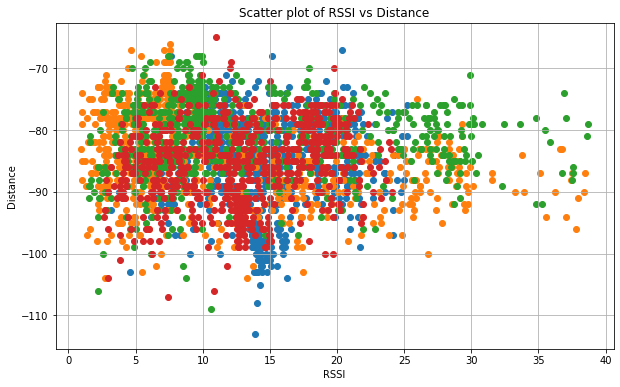

In [28]:
# visualize data for each beacon

import matplotlib.pyplot as plt

# Create a scatter plot with a logarithmic scale for the distances
plt.figure(figsize=(10, 6))
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['rssi'])
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['rssi'])
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['rssi'])
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['rssi'])
plt.xlabel('RSSI')
plt.ylabel('Distance')
plt.title('Scatter plot of RSSI vs Distance')
plt.grid(True)
plt.show()


n = 0.29074450464111457
C = -81.10174711688919


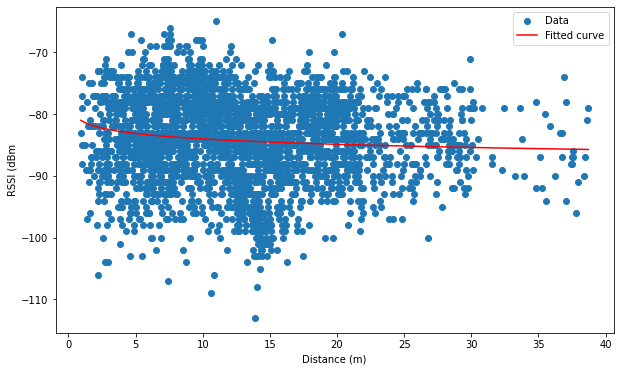

In [29]:
# curve fit with all beacons

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the function to fit
def func(d, n, C):
    return -10 * n * np.log10(d) + C

# Fit the function to the data
popt, pcov = curve_fit(func, df2_interpolated['dist'], df2_interpolated['rssi'])

# Print the optimal parameters
print('n =', popt[0])
print('C =', popt[1])

# Plot the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df2_interpolated['dist'], df2_interpolated['rssi'], label='Data')
distances = np.linspace(df2_interpolated['dist'].min(), df2_interpolated['dist'].max(), 1000)
plt.plot(distances, func(distances, *popt), 'r', label='Fitted curve')
plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dBm')
plt.legend()
plt.show()


n = -0.09913057587791152
C = -86.97965917741055
n = 0.6790236488073552
C = -77.57985598592398
n = -0.09784770564573103
C = -81.70899088366029
n = -0.47669311612358845
C = -91.00812971143695


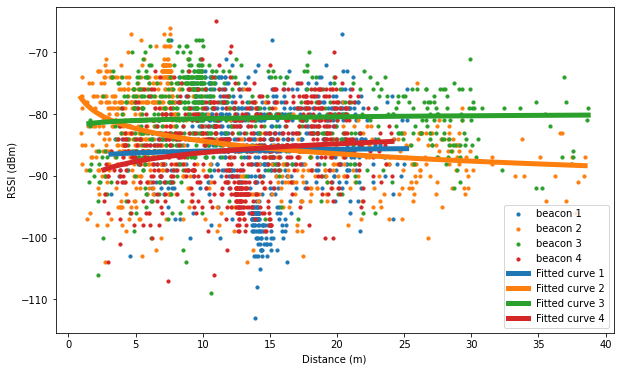

In [30]:
# curve fit with each beacon

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the function to fit
def func(d, n, C):
    return -10 * n * np.log10(d) + C

# Fit the function to the data
popt, pcov = curve_fit(func, df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['rssi'])
popt2, pcov2 = curve_fit(func, df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['rssi'])
popt3, pcov3 = curve_fit(func, df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['rssi'])
popt4, pcov4 = curve_fit(func, df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['rssi'])


# Print the optimal parameters
print('n =', popt[0])
print('C =', popt[1])
# Print the optimal parameters
print('n =', popt2[0])
print('C =', popt2[1])
# Print the optimal parameters
print('n =', popt3[0])
print('C =', popt3[1])
# Print the optimal parameters
print('n =', popt4[0])
print('C =', popt4[1])

# Plot the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['rssi'], label='beacon 1', s=10) # beacon 2
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['rssi'], label='beacon 2', s=10) # beacon 3
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['rssi'], label='beacon 3', s=10) # beacon 4
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['rssi'], label='beacon 4', s=10) # beacon 5
distances = np.linspace(df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['dist'].min(), df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['dist'].max(), 1000)
plt.plot(distances, func(distances, *popt), label='Fitted curve 1', linewidth=5) # beacon 2
distances2 = np.linspace(df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['dist'].min(), df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['dist'].max(), 1000)
plt.plot(distances2, func(distances2, *popt2), label='Fitted curve 2', linewidth=5) # beacon 3
distances3 = np.linspace(df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['dist'].min(), df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['dist'].max(), 1000)
plt.plot(distances3, func(distances3, *popt3), label='Fitted curve 3', linewidth=5) # beacon 4
distances4 = np.linspace(df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['dist'].min(), df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['dist'].max(), 1000)
plt.plot(distances4, func(distances4, *popt4), label='Fitted curve 4', linewidth=5) # beacon 5
plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dBm)')
plt.legend()
plt.show()

In [31]:
# curve fit with each experiment
# might have been covering the beacon while the drone was on the ground

In [32]:
# Select different time spans

start_date1 = '2023-07-14 10:52:30'
end_date1 = '2023-07-14 10:55:30'

start_date2 = '2023-07-14 10:57:00'
end_date2 = '2023-07-14 11:00:00'

# Filter data based on the date ranges
mask1 = (df2_interpolated['received_time'] >= start_date1) & (df2_interpolated['received_time'] <= end_date1)
mask2 = (df2_interpolated['received_time'] >= start_date2) & (df2_interpolated['received_time'] <= end_date2)

# Create a combined mask
mask = mask1 | mask2 

# Apply the mask
df2_interpolated_masked = df2_interpolated.loc[mask]

n = 0.008201367056655195
C = -83.88973503142876


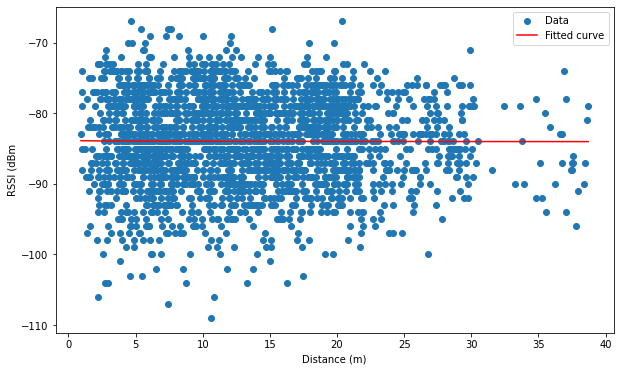

In [33]:
# curve fit with all beacons

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the function to fit
def func(d, n, C):
    return -10 * n * np.log10(d) + C

# Fit the function to the data
popt, pcov = curve_fit(func, df2_interpolated_masked['dist'], df2_interpolated_masked['rssi'])

# Print the optimal parameters
print('n =', popt[0])
print('C =', popt[1])

# Plot the data and the fitted curve
plt.figure(figsize=(10, 6), facecolor="white")
plt.scatter(df2_interpolated_masked['dist'], df2_interpolated_masked['rssi'], label='Data')
distances = np.linspace(df2_interpolated_masked['dist'].min(), df2_interpolated_masked['dist'].max(), 1000)
plt.plot(distances, func(distances, *popt), 'r', label='Fitted curve')
plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dBm')
plt.legend()
plt.show()


n = -0.37291216797736326
C = -88.0756724404557
n = 0.576840942982811
C = -80.19241347649546
n = -0.22907867416250327
C = -84.10767388806033
n = -0.7126145011190026
C = -92.19710258240573


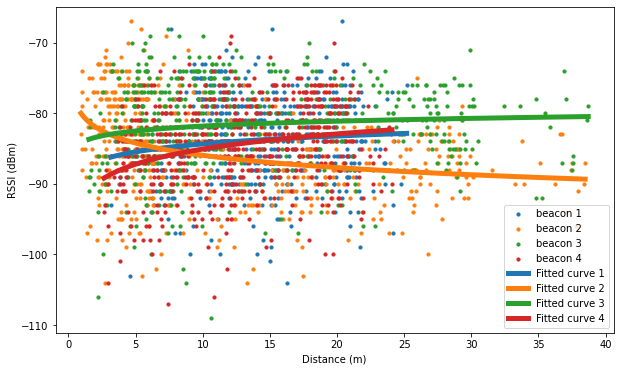

In [34]:
# curve fit with each beacon

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the function to fit
def func(d, n, C):
    return -10 * n * np.log10(d) + C

# Fit the function to the data
popt, pcov = curve_fit(func, df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==2.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==2.0]['rssi'])
popt2, pcov2 = curve_fit(func, df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==3.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==3.0]['rssi'])
popt3, pcov3 = curve_fit(func, df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==4.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==4.0]['rssi'])
popt4, pcov4 = curve_fit(func, df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==5.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==5.0]['rssi'])


# Print the optimal parameters
print('n =', popt[0])
print('C =', popt[1])
# Print the optimal parameters
print('n =', popt2[0])
print('C =', popt2[1])
# Print the optimal parameters
print('n =', popt3[0])
print('C =', popt3[1])
# Print the optimal parameters
print('n =', popt4[0])
print('C =', popt4[1])

# Plot the data and the fitted curve
plt.figure(figsize=(10, 6), facecolor="white")
plt.scatter(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==2.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==2.0]['rssi'], label='beacon 1', s=10) # beacon 2
plt.scatter(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==3.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==3.0]['rssi'], label='beacon 2', s=10) # beacon 3
plt.scatter(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==4.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==4.0]['rssi'], label='beacon 3', s=10) # beacon 4
plt.scatter(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==5.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==5.0]['rssi'], label='beacon 4', s=10) # beacon 5
distances = np.linspace(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==2.0]['dist'].min(), df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==2.0]['dist'].max(), 1000)
plt.plot(distances, func(distances, *popt), label='Fitted curve 1', linewidth=5) # beacon 2
distances2 = np.linspace(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==3.0]['dist'].min(), df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==3.0]['dist'].max(), 1000)
plt.plot(distances2, func(distances2, *popt2), label='Fitted curve 2', linewidth=5) # beacon 3
distances3 = np.linspace(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==4.0]['dist'].min(), df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==4.0]['dist'].max(), 1000)
plt.plot(distances3, func(distances3, *popt3), label='Fitted curve 3', linewidth=5) # beacon 4
distances4 = np.linspace(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==5.0]['dist'].min(), df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==5.0]['dist'].max(), 1000)
plt.plot(distances4, func(distances4, *popt4), label='Fitted curve 4', linewidth=5) # beacon 5
plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dBm)')
plt.legend()
plt.show()